# Analysis & Plots for Asphalt Binder level test results

This notebook include the codes for analysis and plotting the asphalt binder level test results, including the High Temperature Performance Grade (HTPG), Low Temperature Performance Grade (LTPG), ΔTc, Glover-Rowe, Frequency Sweep, Double-Edge Notched Tension (DENT), etc. The test results are provided for the materials from polymer-modified lanes and one control lane in PTF project. 

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov)

Date: 07/02/2025

____

In [1]:
# Importing the required libraries. 
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Binder_LTPG_DeltaTc import Calc_LTPG_DeltaTc
from Binder_DENT import Calc_DENT
from Binder_FrequencySweep import Analyze_FrequencySweep_Data

In [2]:
# User defined variables. 
MainDataFileName = './Data.xlsx'
OutputDir        = '../_Figures'
PLOT             = False

_____

## Reading and Analysis of Input Data

### High Temperature Performance Grade (HTPG)

This section include reading the HTPG results from the input data file. HTPG values for each binder specimen was already calculated, and therefore, there is no specific analysis performed in this section. 

In [3]:
HTPG = pd.read_excel(MainDataFileName, sheet_name='HTPG', usecols='A:F', skiprows=1, 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 'HTPG'])
HTPG.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,HTPG
0,1,0-Month,NaN,7196,1,81.7
1,1,0-Month,NaN,7196,2,81.9
2,1,0-Month,NaN,7196,3,83.0
3,2,0-Month,NaN,7197,1,79.8
4,2,0-Month,NaN,7197,2,80.0


In [4]:
# Aggregate the results and calculate the HTPG into a new "data" DataFrame. 
data = {'Lane': [], 'Field_Aging': [], 'Lab_Aging': [], 'ID': [], 
        'HTPG_avg': [], 'HTPG_std': [], 'HTPG_data': [], 'HTPG_num': []}
for ln in HTPG['Lane'].unique():
    lndf = HTPG[HTPG['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[lndf['Field_Aging'] == age]
        Bnumber = agedf.iloc[0, 3]
        if age == '0-Month':
            # For the recovered binders, just aggregate the results. 
            Avg  = agedf['HTPG'].mean()
            Std  = agedf['HTPG'].std()
            Data = ','.join([f'{num:.2f}' for num in agedf['HTPG'].tolist()])
        elif age == 'Tank binder':
            # For the tank binders, we have both Unaged and RTFO-aged levels, therefore, get the lowest one as HTPG. 
            Unageddf = agedf[agedf['Lab_Aging'] == 'Unaged']
            RTFOdf   = agedf[agedf['Lab_Aging'] == 'RTFO']
            if Unageddf['HTPG'].mean() < RTFOdf['HTPG'].mean():
                Avg  = Unageddf['HTPG'].mean()
                Std  = Unageddf['HTPG'].std()
                Data = ','.join([f'{num:.2f}' for num in Unageddf['HTPG'].tolist()])
            else:
                Avg  = RTFOdf['HTPG'].mean()
                Std  = RTFOdf['HTPG'].std()
                Data = ','.join([f'{num:.2f}' for num in RTFOdf['HTPG'].tolist()])
            
        # Save the results. 
        data['Lane'].append(ln)
        data['Field_Aging'].append(age)
        data['Lab_Aging'].append('N/A')
        data['ID'].append(Bnumber)
        data['HTPG_avg'].append(Avg)
        data['HTPG_std'].append(Std)
        data['HTPG_data'].append(Data)
        data['HTPG_num'].append(len(Data.split(',')))
data = pd.DataFrame(data)
data.head()

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num
0,1,0-Month,N/A,7196,82.200000,0.700000,"81.70,81.90,83.00",3
1,1,Tank binder,N/A,7029,71.700000,0.282843,"71.50,71.90",2
2,2,0-Month,N/A,7197,80.166667,0.472582,"79.80,80.00,80.70",3
3,2,Tank binder,N/A,7046,68.111872,0.201393,"68.25,67.97",2
4,3,0-Month,N/A,7198,77.400000,0.529150,"77.00,77.20,78.00",3


### Low Temperature Performance Grade (LTPG) and ΔTc

This section includes reading the BBR test results for the tank and recovered binders and calculate the LTPG and ΔTc values for each binder. It is noted that the BBR standard recommend only two replicates for testing, which is the case for the Tank binders. However, the ABML lab had managed to run three replicates later on, for the recovered binders. 

In [5]:
LTPG = pd.read_excel(MainDataFileName, sheet_name='BBR (LTPG)', usecols='A:K', skiprows=1, 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 'Temp1', 'mval1', 'Sval1', 'Temp2', 'mval2', 'Sval2'])
LTPG.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,Temp1,mval1,Sval1,Temp2,mval2,Sval2
0,1,0-Month,PAV,7196,1,-12,0.310,235,-18,0.260,419
1,1,0-Month,PAV,7196,2,-12,0.310,228,-18,0.254,385
2,1,0-Month,PAV,7196,3,-12,0.307,206,-18,0.256,456
3,2,0-Month,PAV,7197,1,-12,0.320,200,-18,0.267,391
4,2,0-Month,PAV,7197,2,-12,0.315,201,-18,0.265,391


In [6]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = ['LTPG_avg', 'LTPG_std', 'LTPG_data', 'LTPG_num', 'DeltaTc_avg', 'DeltaTc_std', 'DeltaTc_num']
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[lndf['Field_Aging'] == age]
        if len(agedf) != 1:
            raise Exception(f'More than one record with field aging of {age} and lane number of {ln} found!!')
        else:
            idx = agedf.index[0]
        df = LTPG[(LTPG['Lane'] == ln) & (LTPG['Field_Aging'] == age)]
        # Prepare the inputs.
        LTPGInput = {
            'Temp1': df['Temp1'].to_numpy(), 'mval1': df['mval1'].to_numpy(), 'Sval1': df['Sval1'].to_numpy(), 
            'Temp2': df['Temp2'].to_numpy(), 'mval2': df['mval2'].to_numpy(), 'Sval2': df['Sval2'].to_numpy()}
        # Call the LTPG calculation function to calculate the LTPG and ΔΤc values. 
        Res = Calc_LTPG_DeltaTc(LTPGInput)
        # Save the results into "data" dataframe. 
        data.loc[idx, 'LTPG_avg']    = Res['LTPG_avg']
        data.loc[idx, 'LTPG_std']    = Res['LTPG_std']
        data.loc[idx, 'LTPG_data']   = ','.join(f'{num:.2f}' for num in Res['LTPG'])
        data.loc[idx, 'LTPG_num']    = len(Res['LTPG'])
        data.loc[idx, 'DeltaTc_avg'] = Res['DeltaTc_avg']
        data.loc[idx, 'DeltaTc_std'] = Res['DeltaTc_std']
        data.loc[idx, 'DeltaTc_num'] = len(Res['LTPG'])
data.head()

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num,LTPG_avg,LTPG_std,LTPG_data,LTPG_num,DeltaTc_avg,DeltaTc_std,DeltaTc_num
0,1,0-Month,N/A,7196,82.200000,0.700000,"81.70,81.90,83.00",3,-23.030520,0.146077,"-23.20,-23.07,-23.11,-23.20,-23.07,-23.11,-22....",9.0,-1.352492,0.441669,9.0
1,1,Tank binder,N/A,7029,71.700000,0.282843,"71.50,71.90",2,-25.431983,0.188757,"-25.64,-25.26,-25.60,-25.22",4.0,1.191447,0.274297,4.0
2,2,0-Month,N/A,7197,80.166667,0.472582,"79.80,80.00,80.70",3,-23.818357,0.278667,"-24.26,-24.18,-24.03,-23.88,-23.80,-23.67,-23....",9.0,-1.371470,0.284544,9.0
3,2,Tank binder,N/A,7046,68.111872,0.201393,"68.25,67.97",2,-25.257995,0.719533,"-25.98,-25.98,-24.54,-24.54",4.0,-2.774240,0.843905,4.0
4,3,0-Month,N/A,7198,77.400000,0.529150,"77.00,77.20,78.00",3,-23.503431,0.558225,"-23.84,-23.64,-23.84,-24.08,-23.86,-24.08,-22....",9.0,-1.770079,0.583374,9.0


### Multiple Stress Creep Recovery (MSCR) 

This section includes reading the MSCR test results for the tank and recovered binders and adding the to the "data" dataframe. 

In [7]:
MSCR = pd.read_excel(MainDataFileName, sheet_name='MSCR', usecols='A:M', skiprows=1, 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 'Temp', 'R0.1', 'R3.2', 'Rdiff', 
                            'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'Traffic'])
MSCR.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,Temp,R0.1,R3.2,Rdiff,Jnr0.1,Jnr3.2,Jnrdiff,Traffic
0,1,0-Month,NaN,7196,1,64,0.4296,0.3671,0.145484,0.1889,0.2111,0.117522,E
1,1,0-Month,NaN,7196,2,64,0.4296,0.3673,0.145019,0.1869,0.2088,0.117175,E
2,1,0-Month,NaN,7196,3,64,0.4304,0.3672,0.146840,0.1886,0.2114,0.120891,E
3,2,0-Month,NaN,7197,1,64,0.4222,0.3444,0.184273,0.2432,0.2797,0.150082,E
4,2,0-Month,NaN,7197,2,64,0.4246,0.3452,0.187000,0.2480,0.2864,0.154839,E


In [8]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = [f'{Props}_{Stats}' for Props in ['R0.1', 'R3.2', 'Rdiff', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff']  
           for Stats in ['avg', 'std', 'data']] + ['MSCR_num', 'MSCR_Temp']
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[lndf['Field_Aging'] == age]
        if len(agedf) != 1:
            raise Exception(f'More than one record with field aging of {age} and lane number of {ln} found!!')
        else:
            idx = agedf.index[0]
        df = MSCR[(MSCR['Lane'] == ln) & (MSCR['Field_Aging'] == age)]
        # Save the results into "data" dataframe. 
        for Props in ['R0.1', 'R3.2', 'Rdiff', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff']:
            arr = df[Props].to_numpy()
            data.loc[idx, f'{Props}_avg']  = arr.mean()
            data.loc[idx, f'{Props}_std']  = arr.std()
            data.loc[idx, f'{Props}_data'] = ','.join([f'{num:.6f}' for num in arr])
        data.loc[idx, 'MSCR_num'] = len(df)
        data.loc[idx, 'MSCR_Temp']= df.iloc[0, 5]
data.head()

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num,LTPG_avg,LTPG_std,...,Jnr0.1_std,Jnr0.1_data,Jnr3.2_avg,Jnr3.2_std,Jnr3.2_data,Jnrdiff_avg,Jnrdiff_std,Jnrdiff_data,MSCR_num,MSCR_Temp
0,1,0-Month,N/A,7196,82.200000,0.700000,"81.70,81.90,83.00",3,-23.030520,0.146077,...,0.000881,"0.188900,0.186900,0.188600",0.210433,0.001161,"0.211100,0.208800,0.211400",0.118529,0.001676,"0.117522,0.117175,0.120891",3.0,64.0
1,1,Tank binder,N/A,7029,71.700000,0.282843,"71.50,71.90",2,-25.431983,0.188757,...,0.006730,"0.647300,0.643800,0.631600",0.848833,0.012154,"0.860600,0.853800,0.832100",0.324404,0.005068,"0.329523,0.326188,0.317500",3.0,64.0
2,2,0-Month,N/A,7197,80.166667,0.472582,"79.80,80.00,80.70",3,-23.818357,0.278667,...,0.003029,"0.243200,0.248000,0.240700",0.281100,0.003884,"0.279700,0.286400,0.277200",0.152187,0.001980,"0.150082,0.154839,0.151641",3.0,64.0
3,2,Tank binder,N/A,7046,68.111872,0.201393,"68.25,67.97",2,-25.257995,0.719533,...,0.003822,"1.258600,1.249400,1.255500",1.500067,0.030415,"1.526700,1.516000,1.457500",0.195766,0.024654,"0.213014,0.213382,0.160900",3.0,64.0
4,3,0-Month,N/A,7198,77.400000,0.529150,"77.00,77.20,78.00",3,-23.503431,0.558225,...,0.008511,"0.375600,0.388100,0.396300",0.434233,0.008344,"0.423400,0.435600,0.443700",0.123087,0.003164,"0.127263,0.122391,0.119606",3.0,64.0


### Frequency Sweep

This section includes reading the Frequency Sweep data (|G*|, δ and their corresponding temperature and angular loading frequency), as well as performing the free shifting and fitting the 2S2P1D model. 

In [9]:
# Read the raw data. 
FS = pd.read_excel(MainDataFileName, sheet_name='Binder Frequency Sweep', usecols='A:GR', skiprows=3)
# Re-organize the results into a new Dictionary.
FSdict = {}
RepNumber = [1, 2, 3, 1, 1]
counter = 0
for ln in [1, 2, 3, 4]:
    FSdict[f'L{ln}'] = {}
    for i, age in enumerate(['Unaged', 'Unaged', 'Unaged', 'PAV20', 'PAV40']):
        rep = RepNumber[i]
        if age not in FSdict[f'L{ln}']:
            FSdict[f'L{ln}'][age] = {}
        FSdict[f'L{ln}'][age][f'Rep{rep}'] = {}
        # Read and rename the DataFrame. 
        df = FS.iloc[:, 10*counter:10*(counter+1)]
        ColNames = list(df.columns)
        df.rename(columns={col: col.split('.')[0] for col in df.columns}, inplace=True)
        # Save the data. 
        FSdict[f'L{ln}'][age][f'Rep{rep}']['Data'] = df.copy()
        counter += 1
# ----------------------------------------------------------------------------------------------------------------------
# Perform the analysis.
for ln in [1, 2, 3, 4]:
    for age in FSdict[f'L{ln}']:
        for rep in FSdict[f'L{ln}'][age]:
            Res = Analyze_FrequencySweep_Data(FSdict[f'L{ln}'][age][rep]['Data'])
            # Save the results. 
            FSdict[f'L{ln}'][age][rep]['Data']['Reduced Frequency (rad/s)'] = Res['ReducedFreq']
            FSdict[f'L{ln}'][age][rep]['Shift Coefficients'] = Res['ShiftCoeff']
            FSdict[f'L{ln}'][age][rep]['2S2P1D'] = Res['2S2P1D']

c:\Users\SF.Abdollahi.ctr\OneDrive - DOT OST\__Presentation_Publication\08_PTF5_PolymerModified_Lanes_(TRB)\GitHub_Analysis\Binder_FrequencySweep.py:804: UserWarning: 
Mean Absolute Error (MAE) in phase angle model is more than 1.5° (4.33° > 1.5°). The code is refining the optimization and trying with another randomized seed value! (Iteration 1
  warnings.warn(f'\nMean Absolute Error (MAE) in phase angle model is more than 1.5° ({MAE:.2f}° > 1.5°). ' +
c:\Users\SF.Abdollahi.ctr\OneDrive - DOT OST\__Presentation_Publication\08_PTF5_PolymerModified_Lanes_(TRB)\GitHub_Analysis\Binder_FrequencySweep.py:823: UserWarning: 
	Better solution found! MAE value after 2 iteration = 0.94°
  warnings.warn(f'\n\tBetter solution found! MAE value after {iteration} iteration = {MAE:.2f}°')
c:\Users\SF.Abdollahi.ctr\OneDrive - DOT OST\__Presentation_Publication\08_PTF5_PolymerModified_Lanes_(TRB)\GitHub_Analysis\Binder_FrequencySweep.py:804: UserWarning: 
Mean Absolute Error (MAE) in phase angle model is

In [10]:
# Create new columns for the Parameters in "data". 
NewCols = [f'{Props}_{Stats}' for Props in ['CrossoverFreq', 'RheologicalIndex', 
                                            'FreqAtδ=30', 'FreqAtδ=45', 'G*Atδ=30', 'G*Atδ=45', 
                                            'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa']  
           for Stats in ['avg', 'std', 'data']] + ['MSCR_num', 'MSCR_Temp']
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for lane in FSdict.keys():
    ln = int(lane[1:])
    for age in FSdict[lane].keys():
        for Props, FullProps in zip(
            ['CrossoverFreq', 'RheologicalIndex', 'FreqAtδ=30', 'FreqAtδ=45', 
             'G*Atδ=30', 'G*Atδ=45', 'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa'], 
            ['Crossover Frequency (rad/s)', 'Rheological Index', 
             'Frequency @ δ=30° (rad/s)', 'Frequency @ δ=45° (rad/s)', 
             '|G*| @ δ=30° (Pa)', '|G*| @ δ=45° (Pa)', 
             'Temperature @ δ=30° f=10 rad/s (°C)', 'Temperature @ δ=45° f=10 rad/s (°C)', 
             'Phase angle @ |G*|=10 MPa (°)']):
            DataList = [FSdict[lane][age][rep]['2S2P1D'][FullProps] for rep in FSdict[lane][age].keys()]
            # Find the index in "data" dataframe. 
            if age == 'Unaged':
                LabAging = 'N/A'
            else:
                LabAging = age
            Tempdf = data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == LabAging)]
            if len(Tempdf) == 0:
                # Nothing found. Create a new row. 
                Bnum = data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['ID'].to_list()[0]
                idx = np.max(data.index) + 1
                data.loc[idx, 'Lane'] = ln
                data.loc[idx, 'Field_Aging'] = '0-Month'
                data.loc[idx, 'Lab_Aging'] = LabAging
                data.loc[idx, 'ID'] = Bnum
            elif len(Tempdf) > 1:
                # More than one row found! Error!
                raise Exception('Error! More than one row matches!')
            else:
                idx = Tempdf.index[0]
            # Add the information. 
            data.loc[idx, f'{Props}_data'] = ','.join([f'{num:.15f}' for num in DataList])
            data.loc[idx, f'{Props}_avg']  = np.mean(DataList)
            if len(DataList) > 1:
                data.loc[idx, f'{Props}_std']  = np.std(DataList)
            else:
                data.loc[idx, f'{Props}_std']  = 0
data.head()

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num,LTPG_avg,LTPG_std,...,G*Atδ=45_data,TempAtδ=30_avg,TempAtδ=30_std,TempAtδ=30_data,TempAtδ=45_avg,TempAtδ=45_std,TempAtδ=45_data,PhaseAtG*=10MPa_avg,PhaseAtG*=10MPa_std,PhaseAtG*=10MPa_data
0,1.0,0-Month,N/A,7196.0,82.200000,0.700000,"81.70,81.90,83.00",3.0,-23.030520,0.146077,...,"8753372.409182891249657,9174034.65606838278472...",7.235674,0.720191,"6.218005439563060,7.780216325679117,7.70880163...",22.764115,0.793738,"21.641633894914975,23.332921527903217,23.31779...",44.295802,0.190628,"44.033987083390457,44.371048028633339,44.48237..."
1,1.0,Tank binder,N/A,7029.0,71.700000,0.282843,"71.50,71.90",2.0,-25.431983,0.188757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0-Month,N/A,7197.0,80.166667,0.472582,"79.80,80.00,80.70",3.0,-23.818357,0.278667,...,"9607338.789728086441755,8889693.17651514522731...",5.943821,1.714421,"3.523192984284151,7.034636538166639,7.27363408...",21.450997,1.383300,"19.503181527597587,22.267458615426889,22.58235...",44.175920,0.417869,"44.708647572430550,44.131079087436952,43.68803..."
3,2.0,Tank binder,N/A,7046.0,68.111872,0.201393,"68.25,67.97",2.0,-25.257995,0.719533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,0-Month,N/A,7198.0,77.400000,0.529150,"77.00,77.20,78.00",3.0,-23.503431,0.558225,...,"8437136.114162938669324,8310880.69121657777577...",7.357987,0.976398,"5.980802732056755,8.133489037652708,7.95966783...",22.069355,1.333827,"20.184958984204933,23.085251063491043,22.93785...",43.836811,0.021206,"43.858532431272856,43.808042944599585,43.84385..."


### Glover-Rowe

This section includes reading the |G*| and δ at 10 rad/s and T=44.7°C from DSR test results for the tank and recovered binders and calculating the Glover-Rowe (G-R) to add them to the to the "data" dataframe. 

In [11]:
data

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num,LTPG_avg,LTPG_std,...,G*Atδ=45_data,TempAtδ=30_avg,TempAtδ=30_std,TempAtδ=30_data,TempAtδ=45_avg,TempAtδ=45_std,TempAtδ=45_data,PhaseAtG*=10MPa_avg,PhaseAtG*=10MPa_std,PhaseAtG*=10MPa_data
0,1.0,0-Month,N/A,7196.0,82.200000,0.700000,"81.70,81.90,83.00",3.0,-23.030520,0.146077,...,"8753372.409182891249657,9174034.65606838278472...",7.235674,0.720191,"6.218005439563060,7.780216325679117,7.70880163...",22.764115,0.793738,"21.641633894914975,23.332921527903217,23.31779...",44.295802,0.190628,"44.033987083390457,44.371048028633339,44.48237..."
1,1.0,Tank binder,N/A,7029.0,71.700000,0.282843,"71.50,71.90",2.0,-25.431983,0.188757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0-Month,N/A,7197.0,80.166667,0.472582,"79.80,80.00,80.70",3.0,-23.818357,0.278667,...,"9607338.789728086441755,8889693.17651514522731...",5.943821,1.714421,"3.523192984284151,7.034636538166639,7.27363408...",21.450997,1.383300,"19.503181527597587,22.267458615426889,22.58235...",44.175920,0.417869,"44.708647572430550,44.131079087436952,43.68803..."
3,2.0,Tank binder,N/A,7046.0,68.111872,0.201393,"68.25,67.97",2.0,-25.257995,0.719533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,0-Month,N/A,7198.0,77.400000,0.529150,"77.00,77.20,78.00",3.0,-23.503431,0.558225,...,"8437136.114162938669324,8310880.69121657777577...",7.357987,0.976398,"5.980802732056755,8.133489037652708,7.95966783...",22.069355,1.333827,"20.184958984204933,23.085251063491043,22.93785...",43.836811,0.021206,"43.858532431272856,43.808042944599585,43.84385..."
5,3.0,Tank binder,N/A,7042.0,65.250000,0.070711,"65.20,65.30",2.0,-26.526017,0.122472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,0-Month,N/A,7199.0,82.333333,0.208167,"82.50,82.40,82.10",3.0,-23.882829,0.443500,...,"8610625.394250307232141,7384144.56122682802379...",4.549275,2.655951,"0.794232178208755,6.503318678290894,6.35027294...",21.201244,2.447395,"17.740735828772547,22.988731246035982,22.87426...",43.208018,0.491939,"43.901313331717532,42.811244726884006,42.91149..."
7,4.0,Tank binder,N/A,7116.0,76.900000,0.141421,"77.00,76.80",2.0,-27.210867,0.046234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0-Month,PAV20,7196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4319789.259744576178491,13.322488,0.000000,13.322488288913561,32.433314,0.000000,32.433314405682431,39.904385,0.000000,39.904385406407108
9,1.0,0-Month,PAV40,7196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2218071.102712798397988,20.982526,0.000000,20.982525546462778,42.344879,0.000000,42.344878881295891,36.012313,0.000000,36.012313345752318


### Double-Edge Notched Tenstion (DENT) 

This section includes reading the fracture energy, maximum load, and ligament lengths and areas, then calculating the crack tip opening (CTOD). 

In [12]:
DENT = pd.read_excel(MainDataFileName, sheet_name='DENT', usecols='A:O', skiprows=1, 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 
                            'FracEnergy1', 'FracEnergy2', 'FracEnergy3', 'MaxLoad', 
                            'Ligament1', 'Ligament2', 'Ligament3', 'Area1', 'Area2', 'Area3'])
DENT.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,FracEnergy1,FracEnergy2,FracEnergy3,MaxLoad,Ligament1,Ligament2,Ligament3,Area1,Area2,Area3
0,1,0-Month,NaN,7196,1,0.9460,2.0748,3.9628,56.9,0.005,0.01,0.015,0.00005,0.0001,0.00015
1,1,0-Month,NaN,7196,2,0.9446,2.1107,3.7095,68.1,0.005,0.01,0.015,0.00005,0.0001,0.00015
2,1,0-Month,NaN,7196,3,0.9469,2.3273,3.7794,73.8,0.005,0.01,0.015,0.00005,0.0001,0.00015
3,2,0-Month,NaN,7197,1,0.8630,2.0751,3.4261,59.0,0.005,0.01,0.015,0.00005,0.0001,0.00015
4,2,0-Month,NaN,7197,2,0.9362,1.9416,3.5718,61.2,0.005,0.01,0.015,0.00005,0.0001,0.00015


In [13]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = ['DENT_num', 'CTOD_avg', 'CTOD_std', 'CTOD_data']
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[(lndf['Field_Aging'] == age) & (lndf['Lab_Aging'] == 'N/A')]
        if len(agedf) != 1:
            raise Exception(f'More than one record with field aging of {age} and lane number of {ln} found!!')
        else:
            idx = agedf.index[0]
        df = DENT[(DENT['Lane'] == ln) & (DENT['Field_Aging'] == age)]
        # Calculate the DENT results. 
        DENTInputs = []
        for i in range(len(df)):
            DENTInputs.append({
                'FractureEnergy': np.array([float(df.iloc[i, j]) for j in [5, 6, 7]]), 
                'MaxLoad'       : float(df.iloc[i, 8]), 
                'Ligament'      : np.array([float(df.iloc[i, j]) for j in [9,  10, 11]]), 
                'Area'          : np.array([float(df.iloc[i, j]) for j in [12, 13, 14]])})
        CTOD = Calc_DENT(DENTInputs)
        # Save the results into "data" dataframe. 
        data.loc[idx, 'DENT_num']  = len(DENTInputs)
        data.loc[idx, 'CTOD_avg'] = CTOD.mean()
        data.loc[idx, 'CTOD_std']  = CTOD.std()
        data.loc[idx, 'CTOD_data'] = ','.join([f'{num:.2f}' for num in CTOD])
data.head()

,Lane,Field_Aging,Lab_Aging,ID,HTPG_avg,HTPG_std,HTPG_data,HTPG_num,LTPG_avg,LTPG_std,...,TempAtδ=45_avg,TempAtδ=45_std,TempAtδ=45_data,PhaseAtG*=10MPa_avg,PhaseAtG*=10MPa_std,PhaseAtG*=10MPa_data,DENT_num,CTOD_avg,CTOD_std,CTOD_data
0,1.0,0-Month,N/A,7196.0,82.200000,0.700000,"81.70,81.90,83.00",3.0,-23.030520,0.146077,...,22.764115,0.793738,"21.641633894914975,23.332921527903217,23.31779...",44.295802,0.190628,"44.033987083390457,44.371048028633339,44.48237...",3.0,11.828495,1.390146,"12.77,13.76,13.48,12.87,13.86,13.59,13.51,14.5..."
1,1.0,Tank binder,N/A,7029.0,71.700000,0.282843,"71.50,71.90",2.0,-25.431983,0.188757,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20.918416,0.932992,"22.19,21.11,22.21,21.13,20.76,19.57,20.78,19.60"
2,2.0,0-Month,N/A,7197.0,80.166667,0.472582,"79.80,80.00,80.70",3.0,-23.818357,0.278667,...,21.450997,1.383300,"19.503181527597587,22.267458615426889,22.58235...",44.175920,0.417869,"44.708647572430550,44.131079087436952,43.68803...",3.0,12.794856,0.606765,"12.46,11.91,12.01,12.08,11.53,11.63,12.65,12.1..."
3,2.0,Tank binder,N/A,7046.0,68.111872,0.201393,"68.25,67.97",2.0,-25.257995,0.719533,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.978071,0.552685,"14.77,15.75,14.51,15.49,14.43,15.50,14.15,15.22"
4,3.0,0-Month,N/A,7198.0,77.400000,0.529150,"77.00,77.20,78.00",3.0,-23.503431,0.558225,...,22.069355,1.333827,"20.184958984204933,23.085251063491043,22.93785...",43.836811,0.021206,"43.858532431272856,43.808042944599585,43.84385...",3.0,11.361020,0.598389,"11.23,10.56,10.55,11.55,10.88,10.86,11.79,11.1..."


_________

## Plotting Section

### Useful Temperature Interval (UTI) 

Plotting the HTPG and LTPG to somehow show the UTI for different lanes, under Tank and Recovered states. 

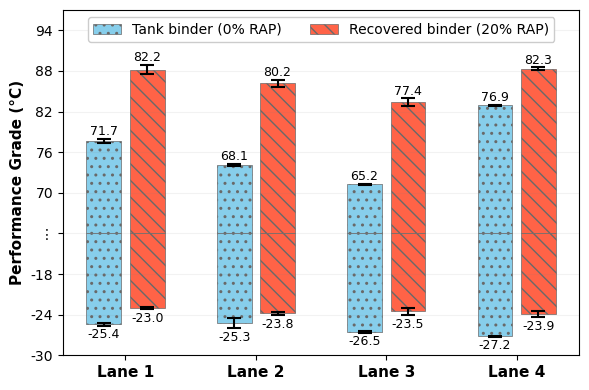

In [14]:
# Plotting the ISO values. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
XPositions = np.array([1,2, 4,5, 7,8, 10,11])
# Calculate the bar heights and error bars. 
HTPG_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['HTPG_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) - 58
HTPG_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['HTPG_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
LTPG_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['LTPG_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) + 12
LTPG_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['LTPG_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
HTPG_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['HTPG_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) - 58
HTPG_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['HTPG_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
LTPG_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['LTPG_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) + 12
LTPG_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['LTPG_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# Plot the bars. 
barHTPG_t  = ax.bar(x=XPositions[[0, 2, 4, 6]], height=HTPG_Tank_avg, yerr=HTPG_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barLTPG_t  = ax.bar(x=XPositions[[0, 2, 4, 6]], height=LTPG_Tank_avg, yerr=LTPG_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barHTPG_r  = ax.bar(x=XPositions[[1, 3, 5, 7]], height=HTPG_Recovered_avg, yerr=HTPG_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barLTPG_r  = ax.bar(x=XPositions[[1, 3, 5, 7]], height=LTPG_Recovered_avg, yerr=LTPG_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2, bar3, bar4] in enumerate(zip(barHTPG_t, barLTPG_t, barHTPG_r, barLTPG_r)):
    ax.text(XPositions[2*i+0], HTPG_Tank_avg[i] + HTPG_Tank_std[i] + 0.1, f'{HTPG_Tank_avg[i] + 58:.1f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    ax.text(XPositions[2*i+1], HTPG_Recovered_avg[i] + HTPG_Recovered_std[i] + 0.1, f'{HTPG_Recovered_avg[i] + 58:.1f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    ax.text(XPositions[2*i+0], LTPG_Tank_avg[i] - LTPG_Tank_std[i] - 0.4, f'{LTPG_Tank_avg[i] - 12:.1f}', 
            ha='center', va='top', fontsize=9, rotation=0)
    ax.text(XPositions[2*i+1], LTPG_Recovered_avg[i] - LTPG_Recovered_std[i] - 0.4, f'{LTPG_Recovered_avg[i] - 12:.1f}', 
            ha='center', va='top', fontsize=9, rotation=0)

# Axis formatting.
ax.yaxis.grid(which='major', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
ax.set_yticks([-18, -12, -6, 0, 6, 12, 18, 24, 30])
ax.set_yticklabels(['-30', '-24', '-18', '⋮', '70', '76', '82', '88', '94'])
ax.set_ylabel('Performance Grade (°C)', color='k', fontsize=11, fontweight='bold')
ax.legend(fontsize=10, ncol=2, fancybox=True, loc='upper center', framealpha=1.0)
ax.set_ylim([-18, 33])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'HTPG_LTPG_UTI.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'HTPG_LTPG_UTI.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'HTPG_LTPG_UTI.svg'), format='svg')

Plotting the ΔΤc data

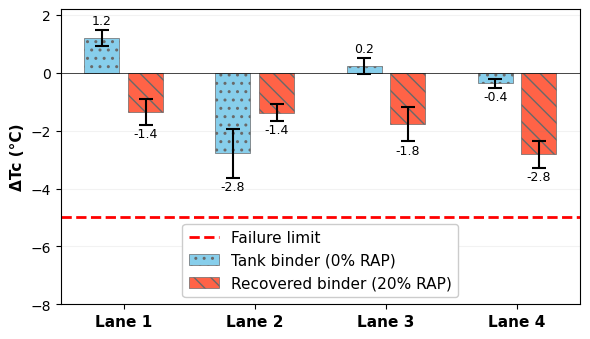

In [15]:
# Plotting the ISO values. 
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
XPositions = np.array([1,2, 4,5, 7,8, 10,11])
# Calculate the bar heights and error bars. 
DeltaTc_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['DeltaTc_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
DeltaTc_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['DeltaTc_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
DeltaTc_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['DeltaTc_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
DeltaTc_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['DeltaTc_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# Plot the bars. 
barDeltaTc_t  = ax.bar(x=XPositions[[0, 2, 4, 6]], height=DeltaTc_Tank_avg, yerr=DeltaTc_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barDeltaTc_r  = ax.bar(x=XPositions[[1, 3, 5, 7]], height=DeltaTc_Recovered_avg, yerr=DeltaTc_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barDeltaTc_t, barDeltaTc_r)):
    if DeltaTc_Tank_avg[i] >= 0:
        ax.text(XPositions[2*i+0], DeltaTc_Tank_avg[i] + DeltaTc_Tank_std[i] + 0.1, f'{DeltaTc_Tank_avg[i]:.1f}', 
                ha='center', va='bottom', fontsize=9, rotation=0)
    else:
        ax.text(XPositions[2*i+0], DeltaTc_Tank_avg[i] - DeltaTc_Tank_std[i] - 0.1, f'{DeltaTc_Tank_avg[i]:.1f}', 
                ha='center', va='top', fontsize=9, rotation=0)
    if DeltaTc_Recovered_avg[i] >= 0:
        ax.text(XPositions[2*i+1], DeltaTc_Recovered_avg[i] + DeltaTc_Recovered_std[i] + 0.1, f'{DeltaTc_Recovered_avg[i]:.1f}', 
                ha='center', va='bottom', fontsize=9, rotation=0)
    else:
        ax.text(XPositions[2*i+1], DeltaTc_Recovered_avg[i] - DeltaTc_Recovered_std[i] - 0.1, f'{DeltaTc_Recovered_avg[i]:.1f}', 
                ha='center', va='top', fontsize=9, rotation=0)
ax.axhline(y=-5, color='r', ls='--', lw=2, label='Failure limit')
ax.axhline(y=0, color='k', ls='-', lw=0.5)
# Axis formatting.
ax.yaxis.grid(which='major', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
ax.set_ylabel('ΔTc (°C)', color='k', fontsize=11, fontweight='bold')
ax.legend(fontsize=11, ncol=1, fancybox=True, loc='lower center', framealpha=1.0)
ax.set_ylim([-8.0, 2.2])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'DeltaTc.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'DeltaTc.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'DeltaTc.svg'), format='svg')

### Multiple Stress Creep Recovery (MSCR)

Plotting the Jnr3.2, Jnrdiff, and R3.2 as the results of MSCR.

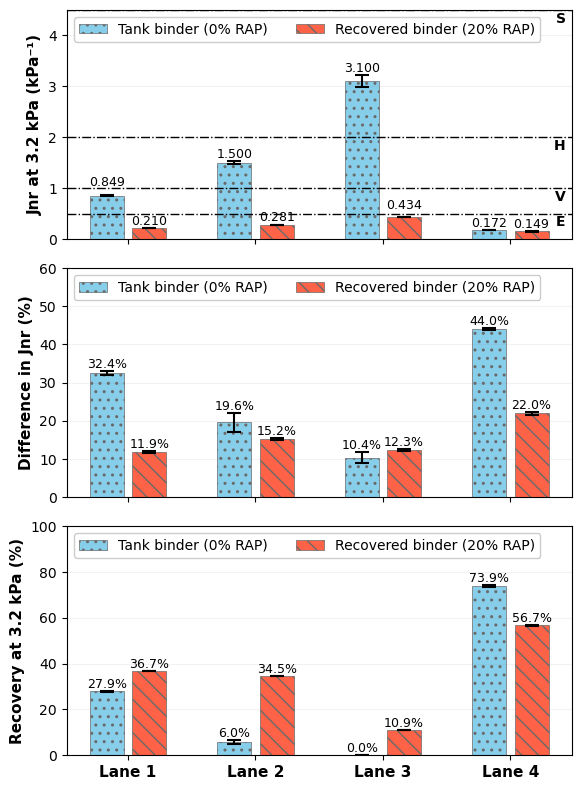

In [16]:
# Plotting the ISO values. 
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
XPositions = np.array([1,2, 4,5, 7,8, 10,11])
# Calculate the bar heights and error bars. 
Jnr32_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnr3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnr3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnr3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnr3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnrd_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnrdiff_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
Jnrd_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnrdiff_std'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
Jnrd_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnrdiff_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
Jnrd_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnrdiff_std'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
R32_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['R3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
R32_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['R3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
R32_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['R3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
R32_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['R3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]]) * 100
# ----------------------------------------------------------------------------------------------------------------------
# PLOT JNR3.2
# Plot the threshold for M332. 
ax[0].axhline(y=0.5, ls='-.', lw=1.0, color='k')
ax[0].axhline(y=1.0, ls='-.', lw=1.0, color='k')
ax[0].axhline(y=2.0, ls='-.', lw=1.0, color='k')
ax[0].axhline(y=4.5, ls='-.', lw=1.0, color='k')
ax[0].text(11.8, 0.47, 'E', ha='right', va='top', fontsize=10, fontweight='bold')
ax[0].text(11.8, 0.97, 'V', ha='right', va='top', fontsize=10, fontweight='bold')
ax[0].text(11.8, 1.97, 'H', ha='right', va='top', fontsize=10, fontweight='bold')
ax[0].text(11.8, 4.47, 'S', ha='right', va='top', fontsize=10, fontweight='bold')
# Plot the bars. 
barJnr32_t  = ax[0].bar(x=XPositions[[0, 2, 4, 6]], height=Jnr32_Tank_avg, yerr=Jnr32_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barJnr32_r  = ax[0].bar(x=XPositions[[1, 3, 5, 7]], height=Jnr32_Recovered_avg, yerr=Jnr32_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
    offset = 0.01 if i != 0 else 0.13
    ax[0].text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    offset = 0.01 if i != 2 else 0.08
    ax[0].text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
ax[0].set_ylabel('Jnr at 3.2 kPa (kPa⁻¹)', color='k', fontsize=11, fontweight='bold')
# ----------------------------------------------------------------------------------------------------------------------
# PLOT Jnrdiff
# Axis formatting.
# Plot the bars. 
barJnrd_t  = ax[1].bar(x=XPositions[[0, 2, 4, 6]], height=Jnrd_Tank_avg, yerr=Jnrd_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barJnrd_r  = ax[1].bar(x=XPositions[[1, 3, 5, 7]], height=Jnrd_Recovered_avg, yerr=Jnrd_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
    ofset = 0.1
    ax[1].text(XPositions[2*i+0], Jnrd_Tank_avg[i] + Jnrd_Tank_std[i] + offset, f'{Jnrd_Tank_avg[i]:.1f}%', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    ax[1].text(XPositions[2*i+1], Jnrd_Recovered_avg[i] + Jnrd_Recovered_std[i] + offset, f'{Jnrd_Recovered_avg[i]:.1f}%', 
            ha='center', va='bottom', fontsize=9, rotation=0)
ax[1].set_ylabel('Difference in Jnr (%)', color='k', fontsize=11, fontweight='bold')
# ----------------------------------------------------------------------------------------------------------------------
# PLOT R3.2
# Axis formatting.
# Plot the bars. 
barJnr32_t  = ax[2].bar(x=XPositions[[0, 2, 4, 6]], height=R32_Tank_avg, yerr=R32_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barJnr32_r  = ax[2].bar(x=XPositions[[1, 3, 5, 7]], height=R32_Recovered_avg, yerr=R32_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
    ofset = 0.1
    ax[2].text(XPositions[2*i+0], R32_Tank_avg[i] + R32_Tank_std[i] + offset, f'{R32_Tank_avg[i]:.1f}%', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    ax[2].text(XPositions[2*i+1], R32_Recovered_avg[i] + R32_Recovered_std[i] + offset, f'{R32_Recovered_avg[i]:.1f}%', 
            ha='center', va='bottom', fontsize=9, rotation=0)
ax[2].set_ylabel('Recovery at 3.2 kPa (%)', color='k', fontsize=11, fontweight='bold')
# ----------------------------------------------------------------------------------------------------------------------
# General plotting settings. 
for i in range(3):
    ax[i].yaxis.grid(which='major', color='gray', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5])
    ax[i].set_xticklabels(['' for j in range(4)])
    ax[i].legend(fontsize=10, ncol=2, fancybox=True, loc='upper left', framealpha=1.0)

ax[0].set_ylim([0, 4.5])
ax[1].set_ylim([0, 60])
ax[2].set_ylim([0, 100])
ax[2].set_xticks([1.5, 4.5, 7.5, 10.5])
ax[2].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')



fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.svg'), format='svg')

Also plotting a single plot of Jnr3.2, if we only use this plot in the manuscript. 

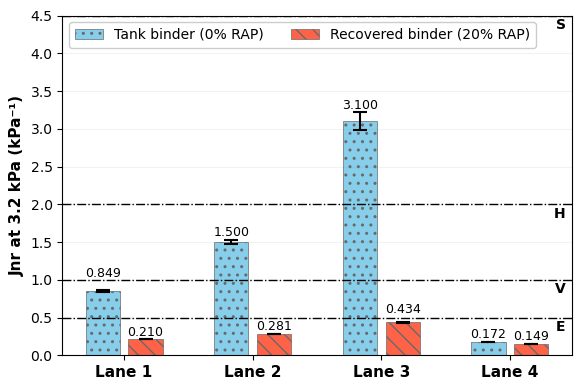

In [17]:
# Plotting the ISO values. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
XPositions = np.array([1,2, 4,5, 7,8, 10,11])
# Calculate the bar heights and error bars. 
Jnr32_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnr3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['Jnr3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnr3.2_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Jnr32_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['Jnr3.2_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# Plot the threshold for M332. 
ax.axhline(y=0.5, ls='-.', lw=1.0, color='k')
ax.axhline(y=1.0, ls='-.', lw=1.0, color='k')
ax.axhline(y=2.0, ls='-.', lw=1.0, color='k')
ax.axhline(y=4.5, ls='-.', lw=1.0, color='k')
ax.text(11.8, 0.47, 'E', ha='right', va='top', fontsize=10, fontweight='bold')
ax.text(11.8, 0.97, 'V', ha='right', va='top', fontsize=10, fontweight='bold')
ax.text(11.8, 1.97, 'H', ha='right', va='top', fontsize=10, fontweight='bold')
ax.text(11.8, 4.47, 'S', ha='right', va='top', fontsize=10, fontweight='bold')
# Plot the bars. 
barJnr32_t  = ax.bar(x=XPositions[[0, 2, 4, 6]], height=Jnr32_Tank_avg, yerr=Jnr32_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barJnr32_r  = ax.bar(x=XPositions[[1, 3, 5, 7]], height=Jnr32_Recovered_avg, yerr=Jnr32_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
    offset = 0.01 if i != 0 else 0.13
    ax.text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    offset = 0.01 if i != 2 else 0.08
    ax.text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)

# Axis formatting.
ax.yaxis.grid(which='major', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
ax.set_ylabel('Jnr at 3.2 kPa (kPa⁻¹)', color='k', fontsize=11, fontweight='bold')
ax.legend(fontsize=10, ncol=2, fancybox=True, loc='upper left', framealpha=1.0)
ax.set_ylim([0, 4.5])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'MSCR_Jnr32.svg'), format='svg')

### DENT 

Plotting the CTOD values for the DENT test. 

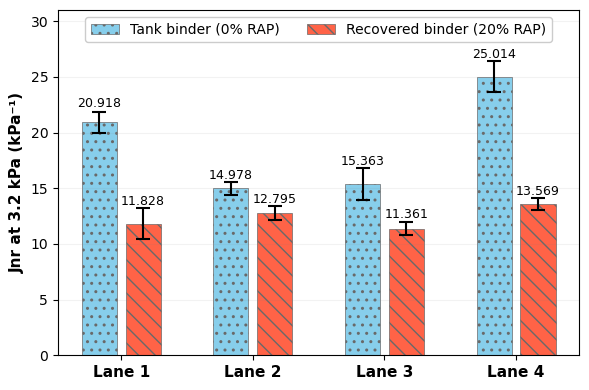

In [18]:
# Plotting the ISO values. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
XPositions = np.array([1,2, 4,5, 7,8, 10,11])
# Calculate the bar heights and error bars. 
CTOD_Tank_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['CTOD_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
CTOD_Tank_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == 'Tank binder')]['CTOD_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
CTOD_Recovered_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['CTOD_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
CTOD_Recovered_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month')]['CTOD_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# Plot the bars. 
barJnr32_t  = ax.bar(x=XPositions[[0, 2, 4, 6]], height=CTOD_Tank_avg, yerr=CTOD_Tank_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Tank binder (0% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barJnr32_r  = ax.bar(x=XPositions[[1, 3, 5, 7]], height=CTOD_Recovered_avg, yerr=CTOD_Recovered_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='Recovered binder (20% RAP)',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
    offset = 0.01 if i != 0 else 0.13
    ax.text(XPositions[2*i+0], CTOD_Tank_avg[i] + CTOD_Tank_std[i] + offset, f'{CTOD_Tank_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    offset = 0.01 if i != 2 else 0.08
    ax.text(XPositions[2*i+1], CTOD_Recovered_avg[i] + CTOD_Recovered_std[i] + offset, f'{CTOD_Recovered_avg[i]:.3f}', 
            ha='center', va='bottom', fontsize=9, rotation=0)

# Axis formatting.
ax.yaxis.grid(which='major', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
ax.set_ylabel('Jnr at 3.2 kPa (kPa⁻¹)', color='k', fontsize=11, fontweight='bold')
ax.legend(fontsize=10, ncol=2, fancybox=True, loc='upper center', framealpha=1.0)
ax.set_ylim([0, 31])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'DENT_CTOD.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'DENT_CTOD.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'DENT_CTOD.svg'), format='svg')

### Frequency Sweep

Plotting the frequency sweep master curves and some other parameters. 

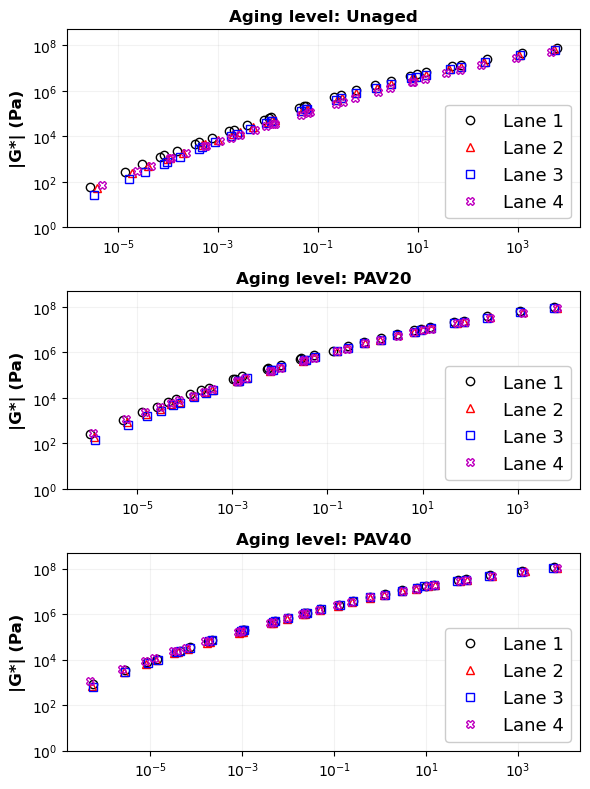

In [ ]:
# Plotting the Option 1: Sorted based on Aging. 
Markers = ['o', '^', 's', 'X', '>', '*', '+', '-', 'd', '<']
Colors  = ['k', 'r', 'b', 'm', 'g', 'k', 'r', 'b', 'm', 'g']
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
for i, age in enumerate(['Unaged', 'PAV20', 'PAV40']):
    for j, ln in enumerate([1, 2, 3, 4]):
        ax[i].loglog(FSdict[f'L{ln}'][age]['Rep1']['Data']['Reduced Frequency (rad/s)'].to_numpy()[::7], 
                     FSdict[f'L{ln}'][age]['Rep1']['Data']['|G*|'].to_numpy()[::7],
                     ls='', marker=Markers[j], color=Colors[j], ms=6, markerfacecolor='none', markeredgewidth=1, 
                     label=f'Lane {ln}', alpha=1)
    # ax[i].set_xlabel('Reduced frequency (rad/s)', fontsize=12, fontweight='bold')
    ax[i].set_ylabel('|G*| (Pa)', fontsize=12, fontweight='bold')
    ax[i].set_title(f'Aging level: {age}', fontsize=12, fontweight='bold')
    ax[i].legend(fontsize=13, ncol=1, loc='lower right', framealpha=1)
    ax[i].grid(which='both', color='gray', alpha=0.1)
    ax[i].set_ylim([1, 5e8])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge.svg'), format='svg')

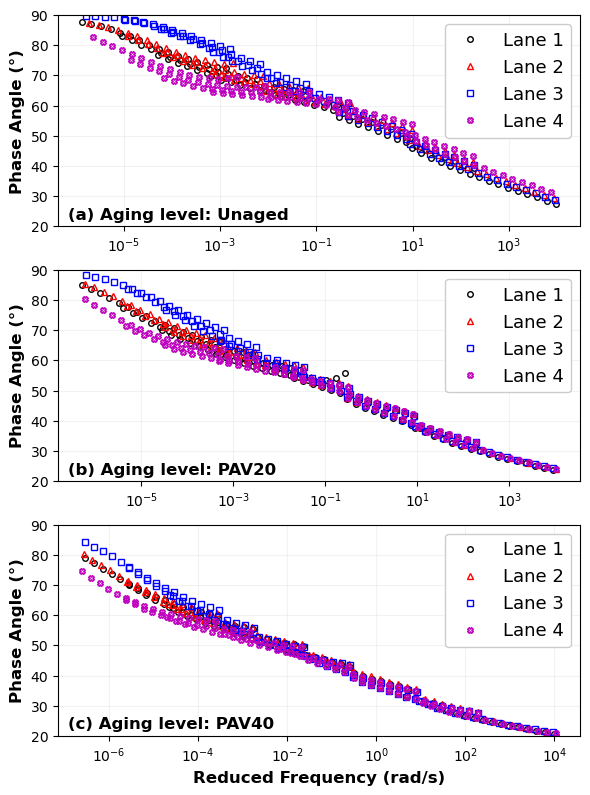

In [60]:
# Plotting the Option 1: Sorted based on Aging. 
Markers = ['o', '^', 's', 'X', '>', '*', '+', '-', 'd', '<']
Colors  = ['k', 'r', 'b', 'm', 'g', 'k', 'r', 'b', 'm', 'g']
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
for i, age in enumerate(['Unaged', 'PAV20', 'PAV40']):
    for j, ln in enumerate([1, 2, 3, 4]):
        ax[i].semilogx(FSdict[f'L{ln}'][age]['Rep1']['Data']['Reduced Frequency (rad/s)'].to_numpy()[::2], 
                     FSdict[f'L{ln}'][age]['Rep1']['Data']['PhaseAngle'].to_numpy()[::2],
                     ls='', marker=Markers[j], color=Colors[j], ms=4, markerfacecolor='none', markeredgewidth=1, 
                     label=f'Lane {ln}', alpha=1)
    # ax[i].set_xlabel('Reduced frequency (rad/s)', fontsize=12, fontweight='bold')
    ax[i].set_ylabel('Phase Angle (°)', fontsize=12, fontweight='bold')
    ax[i].legend(fontsize=13, ncol=1, loc='upper right', framealpha=1)
    ax[i].grid(which='both', color='gray', alpha=0.1)
    ax[i].set_ylim([20, 90])
    ax[i].text(0.02, 0.02, f'{["(a)", "(b)", "(c)"][i]} Aging level: {age}', 
               fontsize=12, fontweight='bold', ha='left', va='bottom', transform=ax[i].transAxes)
ax[2].set_xlabel('Reduced Frequency (rad/s)', fontsize=12, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge_Phase.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge_Phase.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byAge_Phase.svg'), format='svg')

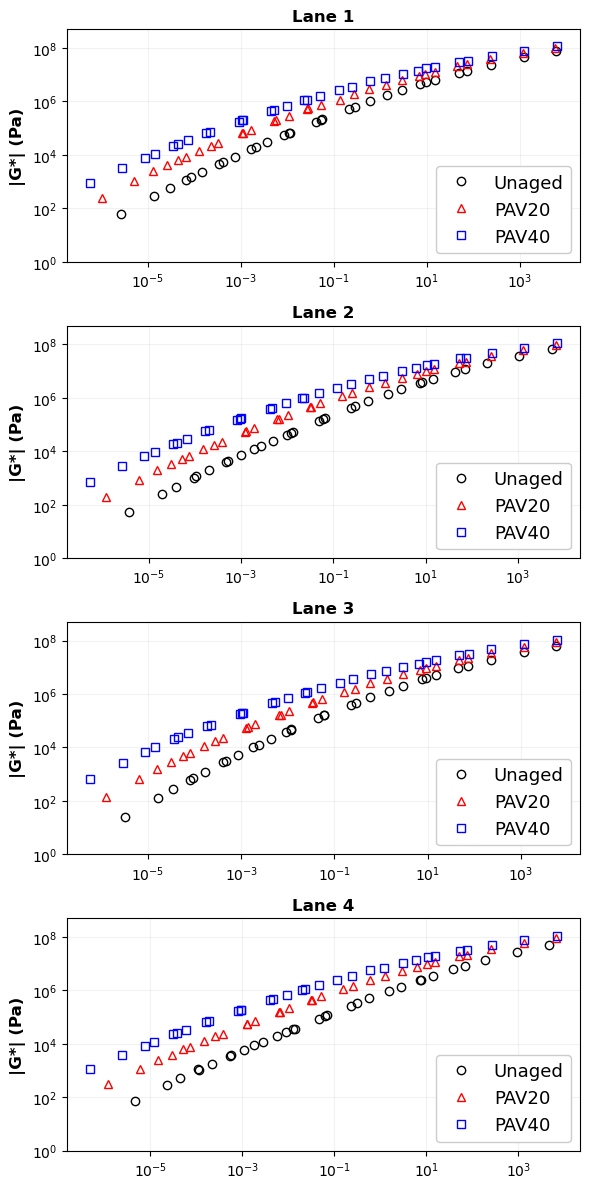

In [20]:
# Plotting the Option 2: Sorted based on lanes. 
Markers = ['o', '^', 's', 'X', '>', '*', '+', '-', 'd', '<']
Colors  = ['k', 'r', 'b', 'm', 'g', 'k', 'r', 'b', 'm', 'g']
fig, ax = plt.subplots(4, 1, figsize=(6, 12))
for j, ln in enumerate([1, 2, 3, 4]):
    for i, age in enumerate(['Unaged', 'PAV20', 'PAV40']):
        ax[j].loglog(FSdict[f'L{ln}'][age]['Rep1']['Data']['Reduced Frequency (rad/s)'].to_numpy()[::7], 
                     FSdict[f'L{ln}'][age]['Rep1']['Data']['|G*|'].to_numpy()[::7],
                     ls='', marker=Markers[i], color=Colors[i], ms=6, markerfacecolor='none', markeredgewidth=1, 
                     label=age, alpha=1)
    # ax[j].set_xlabel('Reduced frequency (rad/s)', fontsize=12, fontweight='bold')
    ax[j].set_ylabel('|G*| (Pa)', fontsize=12, fontweight='bold')
    ax[j].set_title(f'Lane {ln}', fontsize=12, fontweight='bold')
    ax[j].legend(fontsize=13, ncol=1, loc='lower right', framealpha=1)
    ax[j].grid(which='both', color='gray', alpha=0.1)
    ax[j].set_ylim([1, 5e8])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane.svg'), format='svg')

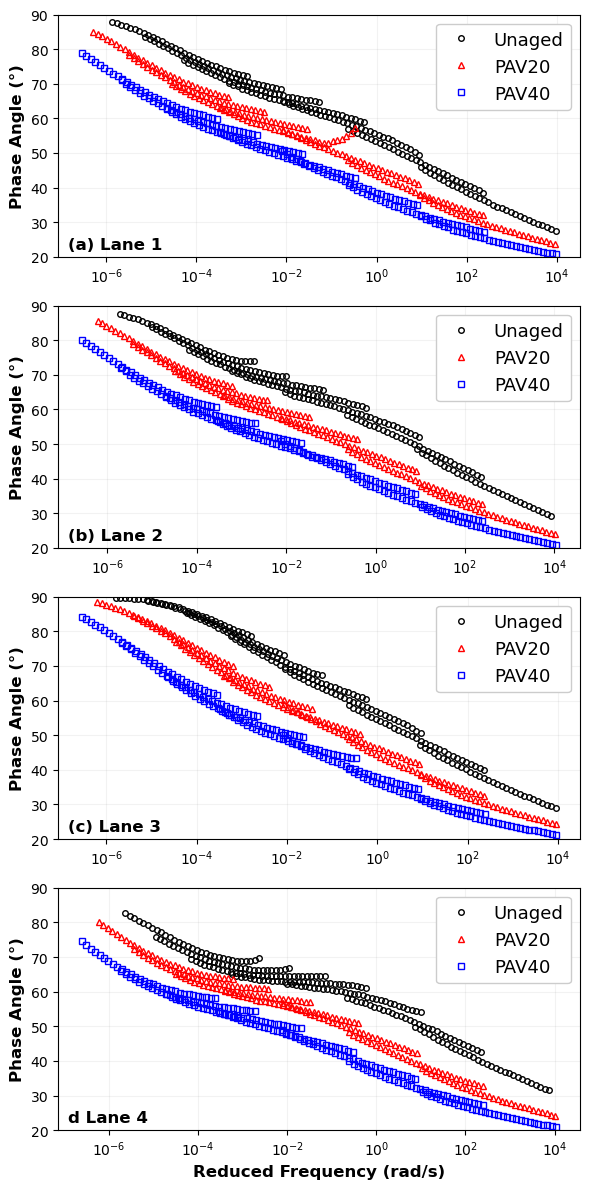

In [58]:
# Plotting the Option 2: Sorted based on lanes. 
Markers = ['o', '^', 's', 'X', '>', '*', '+', '-', 'd', '<']
Colors  = ['k', 'r', 'b', 'm', 'g', 'k', 'r', 'b', 'm', 'g']
fig, ax = plt.subplots(4, 1, figsize=(6, 12))
for j, ln in enumerate([1, 2, 3, 4]):
    for i, age in enumerate(['Unaged', 'PAV20', 'PAV40']):
        ax[j].semilogx(FSdict[f'L{ln}'][age]['Rep1']['Data']['Reduced Frequency (rad/s)'].to_numpy()[::1], 
                       FSdict[f'L{ln}'][age]['Rep1']['Data']['PhaseAngle'].to_numpy()[::1],
                       ls='', marker=Markers[i], color=Colors[i], ms=4, markerfacecolor='none', markeredgewidth=1, 
                       label=age, alpha=1)
    # ax[j].set_xlabel('Reduced frequency (rad/s)', fontsize=12, fontweight='bold')
    ax[j].set_ylabel('Phase Angle (°)', fontsize=12, fontweight='bold')
    ax[j].legend(fontsize=13, ncol=1, loc='upper right', framealpha=1)
    ax[j].grid(which='both', color='gray', alpha=0.1)
    ax[j].set_ylim([20, 90])
    ax[j].text(0.02, 0.02, f'{["(a)", "(b)", "(c)", "d"][j]} Lane {ln}', fontsize=12, fontweight='bold', 
               ha='left', va='bottom', transform=ax[j].transAxes)
ax[-1].set_xlabel('Reduced Frequency (rad/s)', fontsize=12, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane_Phase.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane_Phase.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_byLane_Phase.svg'), format='svg')

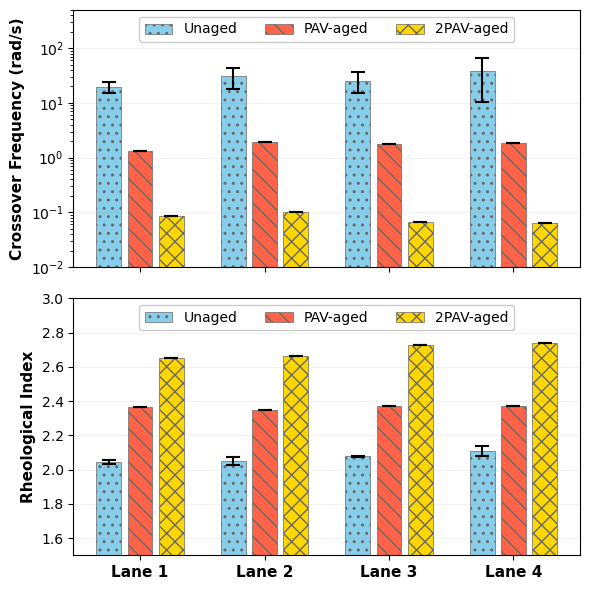

In [21]:
# Plotting the Crossover frequency and Rheological index.
 # Plotting the ISO values. 
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
XPositions = np.array([1,2,3, 5,6,7, 9,10,11, 13,14,15])
# Calculate the bar heights and error bars. 
['CrossoverFreq', 'RheologicalIndex', 'FreqAtδ=30', 'FreqAtδ=45', 'G*Atδ=30', 'G*Atδ=45', 'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa']  
p1 = 'CrossoverFreq'; lbl1='Crossover Frequency (rad/s)'
Prop1_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
p2 = 'RheologicalIndex'; lbl2 = 'Rheological Index'
Prop2_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# ----------------------------------------------------------------------------------------------------------------------
# Plot the bars for the first axes. 
barP1A1 = ax[0].bar(x=XPositions[0::3], height=Prop1_Unaged_avg, yerr=Prop1_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[0].bar(x=XPositions[1::3], height=Prop1_PAV20_avg, yerr=Prop1_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[0].bar(x=XPositions[2::3], height=Prop1_PAV40_avg, yerr=Prop1_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     offset = 0.01 if i != 0 else 0.13
#     ax[0].text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     offset = 0.01 if i != 2 else 0.08
#     ax[0].text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[0].set_ylabel(lbl1, color='k', fontsize=11, fontweight='bold')
ax[0].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# Second plot.
# Plot the bars. 
barP1A1 = ax[1].bar(x=XPositions[0::3], height=Prop2_Unaged_avg, yerr=Prop2_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[1].bar(x=XPositions[1::3], height=Prop2_PAV20_avg, yerr=Prop2_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[1].bar(x=XPositions[2::3], height=Prop2_PAV40_avg, yerr=Prop2_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     ofset = 0.1
#     ax[1].text(XPositions[2*i+0], Jnrd_Tank_avg[i] + Jnrd_Tank_std[i] + offset, f'{Jnrd_Tank_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     ax[1].text(XPositions[2*i+1], Jnrd_Recovered_avg[i] + Jnrd_Recovered_std[i] + offset, f'{Jnrd_Recovered_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[1].set_ylabel(lbl2, color='k', fontsize=11, fontweight='bold')
# ----------------------------------------------------------------------------------------------------------------------
# General plotting settings. 
for i in range(2):
    ax[i].yaxis.grid(which='major', color='gray', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_xticks(XPositions[1::3])
    ax[i].set_xticklabels(['' for j in range(4)])
    ax[i].legend(fontsize=10, ncol=3, fancybox=True, loc='upper center', framealpha=1.0)
ax[0].set_ylim([1e-2, 5e2])
ax[1].set_ylim([1.5, 3.0])
ax[1].set_xticks(XPositions[1::3])
ax[1].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_wc_R.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_wc_R.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_wc_R.svg'), format='svg')

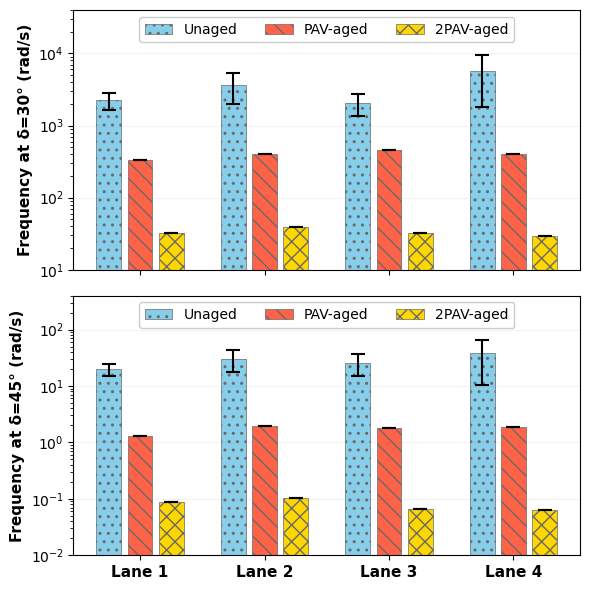

In [22]:
# Plotting the Crossover frequency and Rheological index.
 # Plotting the ISO values. 
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
XPositions = np.array([1,2,3, 5,6,7, 9,10,11, 13,14,15])
# Calculate the bar heights and error bars. 
['CrossoverFreq', 'RheologicalIndex', 'FreqAtδ=30', 'FreqAtδ=45', 'G*Atδ=30', 'G*Atδ=45', 'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa']  
p1 = 'FreqAtδ=30'; lbl1='Frequency at δ=30° (rad/s)'
Prop1_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
p2 = 'FreqAtδ=45'; lbl2 = 'Frequency at δ=45° (rad/s)'
Prop2_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# ----------------------------------------------------------------------------------------------------------------------
# Plot the bars for the first axes. 
barP1A1 = ax[0].bar(x=XPositions[0::3], height=Prop1_Unaged_avg, yerr=Prop1_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[0].bar(x=XPositions[1::3], height=Prop1_PAV20_avg, yerr=Prop1_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[0].bar(x=XPositions[2::3], height=Prop1_PAV40_avg, yerr=Prop1_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     offset = 0.01 if i != 0 else 0.13
#     ax[0].text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     offset = 0.01 if i != 2 else 0.08
#     ax[0].text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[0].set_ylabel(lbl1, color='k', fontsize=11, fontweight='bold')
ax[0].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# Second plot.
# Plot the bars. 
barP1A1 = ax[1].bar(x=XPositions[0::3], height=Prop2_Unaged_avg, yerr=Prop2_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[1].bar(x=XPositions[1::3], height=Prop2_PAV20_avg, yerr=Prop2_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[1].bar(x=XPositions[2::3], height=Prop2_PAV40_avg, yerr=Prop2_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     ofset = 0.1
#     ax[1].text(XPositions[2*i+0], Jnrd_Tank_avg[i] + Jnrd_Tank_std[i] + offset, f'{Jnrd_Tank_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     ax[1].text(XPositions[2*i+1], Jnrd_Recovered_avg[i] + Jnrd_Recovered_std[i] + offset, f'{Jnrd_Recovered_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[1].set_ylabel(lbl2, color='k', fontsize=11, fontweight='bold')
ax[1].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# General plotting settings. 
for i in range(2):
    ax[i].yaxis.grid(which='major', color='gray', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_xticks(XPositions[1::3])
    ax[i].set_xticklabels(['' for j in range(4)])
    ax[i].legend(fontsize=10, ncol=3, fancybox=True, loc='upper center', framealpha=1.0)
ax[0].set_ylim([1e1, 4e4])
ax[1].set_ylim([1e-2, 4e2])
ax[1].set_xticks(XPositions[1::3])
ax[1].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_FreqAtδ=30_45.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_FreqAtδ=30_45.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_FreqAtδ=30_45.svg'), format='svg')

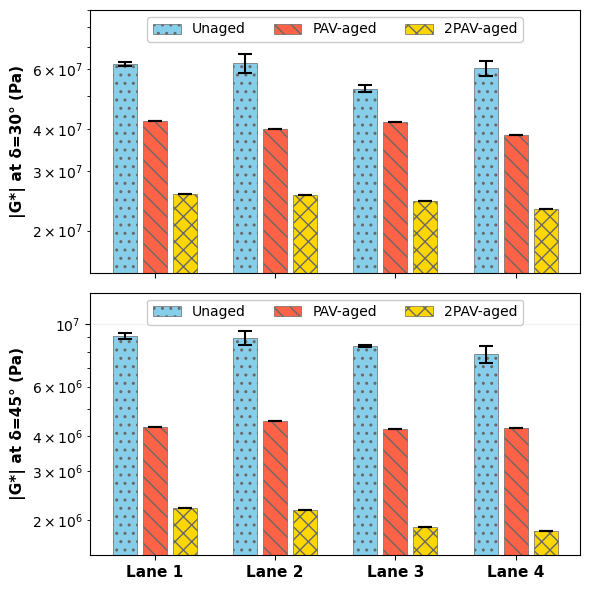

In [23]:
# Plotting the Crossover frequency and Rheological index.
 # Plotting the ISO values. 
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
XPositions = np.array([1,2,3, 5,6,7, 9,10,11, 13,14,15])
# Calculate the bar heights and error bars. 
['G*Atδ=30', 'G*Atδ=45', 'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa']  
p1 = 'G*Atδ=30'; lbl1='|G*| at δ=30° (Pa)'
Prop1_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
p2 = 'G*Atδ=45'; lbl2 = '|G*| at δ=45° (Pa)'
Prop2_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# ----------------------------------------------------------------------------------------------------------------------
# Plot the bars for the first axes. 
barP1A1 = ax[0].bar(x=XPositions[0::3], height=Prop1_Unaged_avg, yerr=Prop1_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[0].bar(x=XPositions[1::3], height=Prop1_PAV20_avg, yerr=Prop1_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[0].bar(x=XPositions[2::3], height=Prop1_PAV40_avg, yerr=Prop1_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     offset = 0.01 if i != 0 else 0.13
#     ax[0].text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     offset = 0.01 if i != 2 else 0.08
#     ax[0].text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[0].set_ylabel(lbl1, color='k', fontsize=11, fontweight='bold')
ax[0].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# Second plot.
# Plot the bars. 
barP1A1 = ax[1].bar(x=XPositions[0::3], height=Prop2_Unaged_avg, yerr=Prop2_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[1].bar(x=XPositions[1::3], height=Prop2_PAV20_avg, yerr=Prop2_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[1].bar(x=XPositions[2::3], height=Prop2_PAV40_avg, yerr=Prop2_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     ofset = 0.1
#     ax[1].text(XPositions[2*i+0], Jnrd_Tank_avg[i] + Jnrd_Tank_std[i] + offset, f'{Jnrd_Tank_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     ax[1].text(XPositions[2*i+1], Jnrd_Recovered_avg[i] + Jnrd_Recovered_std[i] + offset, f'{Jnrd_Recovered_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[1].set_ylabel(lbl2, color='k', fontsize=11, fontweight='bold')
ax[1].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# General plotting settings. 
for i in range(2):
    ax[i].yaxis.grid(which='major', color='gray', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_xticks(XPositions[1::3])
    ax[i].set_xticklabels(['' for j in range(4)])
    ax[i].legend(fontsize=10, ncol=3, fancybox=True, loc='upper center', framealpha=1.0)
ax[0].set_ylim([1.5e7, 9e7])
ax[1].set_ylim([1.5e6, 1.3e7])
ax[1].set_xticks(XPositions[1::3])
ax[1].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_GstarAtδ=30_45.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_GstarAtδ=30_45.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_GstarAtδ=30_45.svg'), format='svg')

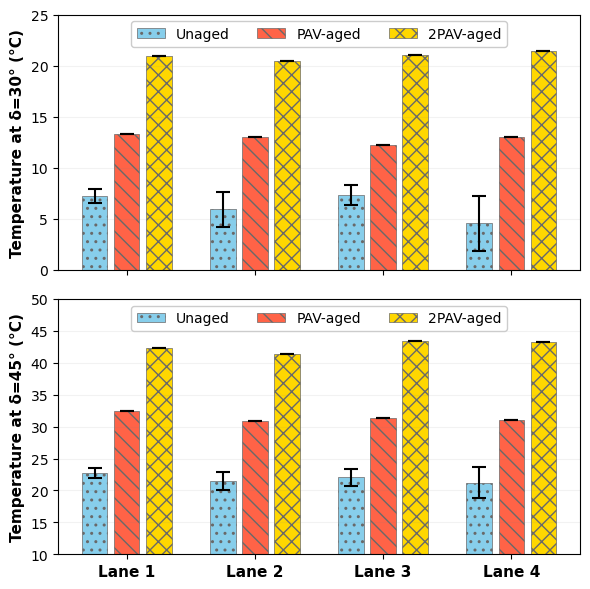

In [ ]:
# Plotting the Crossover frequency and Rheological index.
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
XPositions = np.array([1,2,3, 5,6,7, 9,10,11, 13,14,15])
# Calculate the bar heights and error bars. 
['G*Atδ=30', 'G*Atδ=45', 'TempAtδ=30', 'TempAtδ=45', 'PhaseAtG*=10MPa']  
p1 = 'TempAtδ=30'; lbl1='Temperature at δ=30° (°C)'
Prop1_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop1_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p1}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
p2 = 'TempAtδ=45'; lbl2 = 'Temperature at δ=45° (°C)'
Prop2_Unaged_avg = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_Unaged_std = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'N/A')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV20_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV20')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_avg  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_avg'].to_numpy()[0] for ln in [1, 2, 3, 4]])
Prop2_PAV40_std  = np.array([data[(data['Lane'] == ln) & (data['Field_Aging'] == '0-Month') & (data['Lab_Aging'] == 'PAV40')][f'{p2}_std'].to_numpy()[0] for ln in [1, 2, 3, 4]])
# ----------------------------------------------------------------------------------------------------------------------
# Plot the bars for the first axes. 
barP1A1 = ax[0].bar(x=XPositions[0::3], height=Prop1_Unaged_avg, yerr=Prop1_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[0].bar(x=XPositions[1::3], height=Prop1_PAV20_avg, yerr=Prop1_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[0].bar(x=XPositions[2::3], height=Prop1_PAV40_avg, yerr=Prop1_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     offset = 0.01 if i != 0 else 0.13
#     ax[0].text(XPositions[2*i+0], Jnr32_Tank_avg[i] + Jnr32_Tank_std[i] + offset, f'{Jnr32_Tank_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     offset = 0.01 if i != 2 else 0.08
#     ax[0].text(XPositions[2*i+1], Jnr32_Recovered_avg[i] + Jnr32_Recovered_std[i] + offset, f'{Jnr32_Recovered_avg[i]:.3f}', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[0].set_ylabel(lbl1, color='k', fontsize=11, fontweight='bold')
# ax[0].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# Second plot. 
barP1A1 = ax[1].bar(x=XPositions[0::3], height=Prop2_Unaged_avg, yerr=Prop2_Unaged_std, width=0.8,
                    edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='Unaged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A2 = ax[1].bar(x=XPositions[1::3], height=Prop2_PAV20_avg, yerr=Prop2_PAV20_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
barP1A3 = ax[1].bar(x=XPositions[2::3], height=Prop2_PAV40_avg, yerr=Prop2_PAV40_std, width=0.8, 
                    edgecolor='dimgray', lw=0.5, color='gold', hatch='XX', label='2PAV-aged',
                    error_kw={'capsize': 5, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i, [bar1, bar2] in enumerate(zip(barJnr32_t, barJnr32_r)):
#     ofset = 0.1
#     ax[1].text(XPositions[2*i+0], Jnrd_Tank_avg[i] + Jnrd_Tank_std[i] + offset, f'{Jnrd_Tank_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
#     ax[1].text(XPositions[2*i+1], Jnrd_Recovered_avg[i] + Jnrd_Recovered_std[i] + offset, f'{Jnrd_Recovered_avg[i]:.1f}%', 
#             ha='center', va='bottom', fontsize=9, rotation=0)
ax[1].set_ylabel(lbl2, color='k', fontsize=11, fontweight='bold')
# ax[1].set_yscale('log')
# ----------------------------------------------------------------------------------------------------------------------
# General plotting settings. 
for i in range(2):
    ax[i].yaxis.grid(which='major', color='gray', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_xticks(XPositions[1::3])
    ax[i].set_xticklabels(['' for j in range(4)])
    ax[i].legend(fontsize=10, ncol=3, fancybox=True, loc='upper center', framealpha=1.0)
ax[0].set_ylim([0, 25])
ax[1].set_ylim([10, 50])
ax[1].set_xticks(XPositions[1::3])
ax[1].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'FS_MC_TempAtδ=30_45.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'FS_MC_TempAtδ=30_45.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'FS_MC_TempAtδ=30_45.svg'), format='svg')